# Compute GitHub Stats

In [1]:
# NOTE: The RuntimeWarnings (if any) are harmless. See ContinuumIO/anaconda-issues#6678.
from pandas.io import gbq
import pandas as pd
import numpy as np

from importlib import reload
import itertools

In [2]:
import getpass
import subprocess
# Configuration Variables. Modify as desired.

PROJECT = subprocess.check_output(["gcloud", "config", "get-value", "project"]).strip().decode()

In [10]:
%matplotlib

Using matplotlib backend: GTK3Agg


## Setup Authorization

If you are using a service account run
%%bash

# Activate Service Account provided by Kubeflow.
gcloud auth activate-service-account --key-file=${GOOGLE_APPLICATION_CREDENTIALS}

If you are running using user credentials

gcloud auth application-default login

In [3]:
import datetime
datetime.datetime.now().month

11

In [4]:
months = []
for year in ["2018"]:
    for month in range(1, 13):
        months.append("\"{0}{1:02}\"".format(year, month))

        
for year in ["2019"]:
    for month in range(1, datetime.datetime.now().month + 1):
        months.append("\"{0}{1:02}\"".format(year, month))
months

['"201801"',
 '"201802"',
 '"201803"',
 '"201804"',
 '"201805"',
 '"201806"',
 '"201807"',
 '"201808"',
 '"201809"',
 '"201810"',
 '"201811"',
 '"201812"',
 '"201901"',
 '"201902"',
 '"201903"',
 '"201904"',
 '"201905"',
 '"201906"',
 '"201907"',
 '"201908"',
 '"201909"',
 '"201910"',
 '"201911"']

## Unique PR Creators

In [5]:
query = """
SELECT
    DATE(created_at) AS pr_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.user.id') as user_id,
    JSON_EXTRACT(payload, '$.pull_request.id') as pr_id,
    JSON_EXTRACT(payload, '$.pull_request.merged') as merged
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"closed"')
""".format(",".join(months))

all_prs=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
# Filter PRs to merged PRs
v=all_prs["merged"].values == 'true'
merged_all_prs = all_prs.iloc[v]

In [7]:
p=pd.Series(data=merged_all_prs["user_id"].values,index=merged_all_prs["pr_date"])
p=p.sort_index()

In [8]:
# Some solutions here: https://stackoverflow.com/questions/46470743/how-to-efficiently-compute-a-rolling-unique-count-in-a-pandas-time-series
# Need to figure out how to do a time based window

creators = p.rolling('28d').apply(lambda arr: pd.Series(arr).nunique())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


Text(0, 0.5, '# Authors')

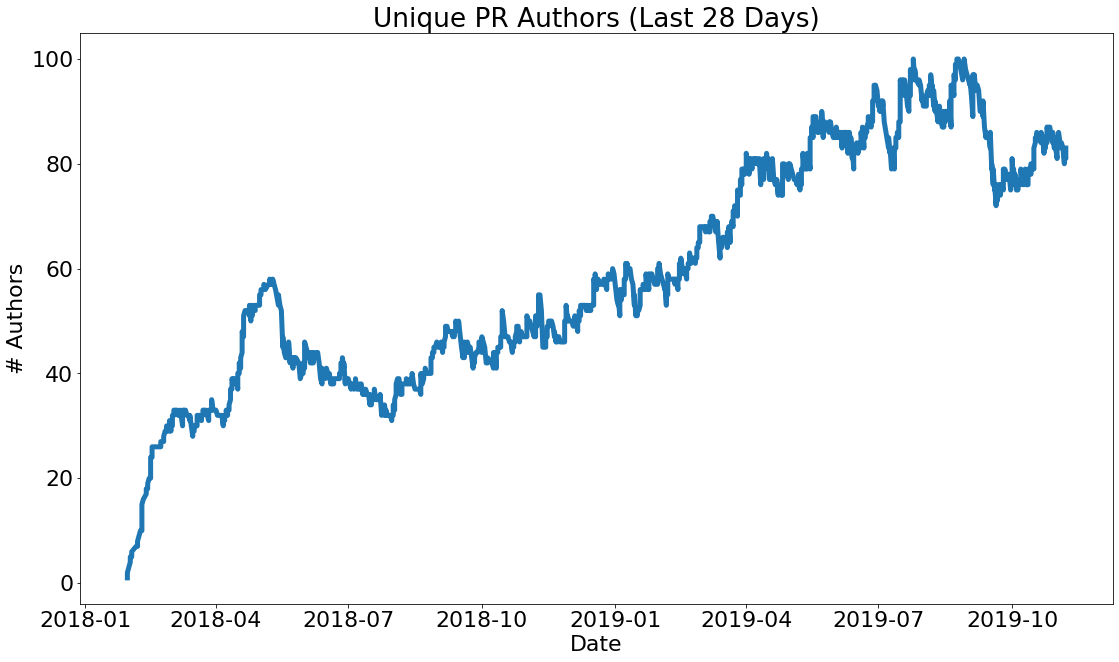

In [12]:
import matplotlib
from matplotlib import pylab
matplotlib.rcParams.update({'font.size': 22})
hf = pylab.figure()
hf.set_size_inches(18.5, 10.5)
pylab.plot(creators, linewidth=5)
ha = pylab.gca()
ha.set_title("Unique PR Authors (Last 28 Days)")
ha.set_xlabel("Date")
ha.set_ylabel("# Authors")

### Number Prs

In [13]:
pr_impulse=pd.Series(data=merged_all_prs["pr_id"].values,index=merged_all_prs["pr_date"])
pr_impulse=pr_impulse.sort_index()

unique_prs = pr_impulse.rolling('28d').apply(lambda arr: pd.Series(arr).nunique())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


Text(0, 0.5, '# PRs')

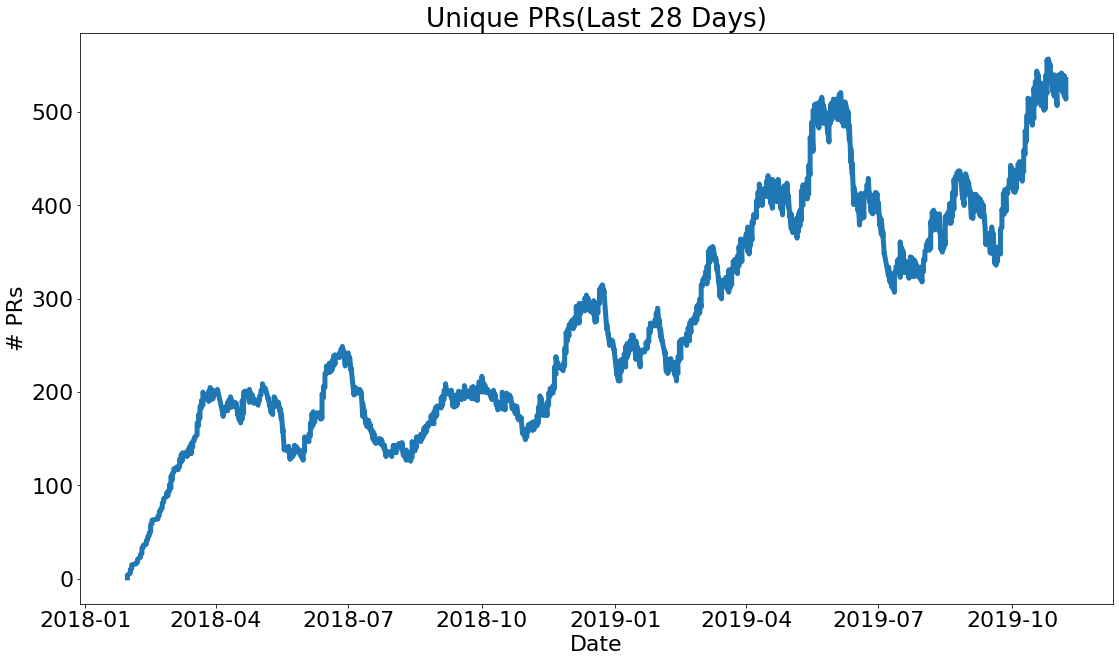

In [15]:

hf = pylab.figure()
hf.set_size_inches(18.5, 10.5)
pylab.plot(unique_prs, linewidth=5)
ha = pylab.gca()
ha.set_title("Unique PRs(Last 28 Days)")
ha.set_xlabel("Date")
ha.set_ylabel("# PRs")

## Release stats per release (quarter)

* Compute stats about a release 
* We do this based on time
* You can see a sample of the payload at [https://api.github.com/repos/kubeflow/pipelines/pulls/1038](https://api.github.com/repos/kubeflow/pipelines/pulls/1038)

In [16]:
release_months = []
year = 2019


for month in range(8, 11):
    release_months.append("\"{0}{1:02}\"".format(year, month))
        

query = """
SELECT
    DATE(created_at) AS pr_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.merged') as merged,
    JSON_EXTRACT(payload, '$.pull_request.id') as pr_id,
    JSON_EXTRACT(payload, '$.pull_request.url') as pr_url,
    JSON_EXTRACT(payload, '$.pull_request.user.id') as user_id
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"closed"')
""".format(",".join(release_months))

prs=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [17]:
# Filter PRs to merged PRs
v=prs["merged"].values == 'true'
merged_prs = prs.iloc[v]

In [18]:
unique_pr_logins = prs["user_id"].unique()
unique_prs = prs["pr_id"].unique()

merged_unique_logins = merged_prs["user_id"].unique()
merged_unique_prs = merged_prs["pr_id"].unique()
print("Number of unique pr authors (merged & unmerged) {0}".format(unique_pr_logins.shape))
print("Number of unique prs (merged & unmerged) {0}".format(unique_prs.shape))
print("Number of unique pr authors (merged) {0}".format(merged_unique_logins.shape))
print("Number of unique prs (merged) {0}".format(merged_unique_prs.shape))

Number of unique pr authors (merged & unmerged) (190,)
Number of unique prs (merged & unmerged) (1788,)
Number of unique pr authors (merged) (155,)
Number of unique prs (merged) (1492,)


## Get a list of distinct actions

* Here's a list of events in the [api](https://developer.github.com/v4/union/pullrequesttimelineitems/)
* It looks like these are different from the ones in the github archive

In [ ]:
query = """
SELECT
    distinct JSON_EXTRACT(payload, '$.action')
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})    
""".format(",".join(months))

actions=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [ ]:
actions

## New Issues Last 28 Days

In [ ]:
query = """
SELECT
    DATE(created_at) AS issue_date,
    actor.id,
    actor.login,
    JSON_EXTRACT(payload, '$.pull_request.id') as issue_id,
    JSON_EXTRACT(payload, '$.pull_request.url') as issue_url  
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'IssuesEvent'
    AND org.login = 'kubeflow'
    AND JSON_EXTRACT(payload, '$.action') IN ('"opened"')
""".format(",".join(months))

issues=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [ ]:
issue_counts=issues["issue_date"].value_counts()
issue_counts=issue_counts.sort_index()
rolling_issue_count = issue_counts.rolling('28d').sum()

In [ ]:
import matplotlib
from matplotlib import pylab
matplotlib.rcParams.update({'font.size': 22})
hf = pylab.figure()
hf.set_size_inches(18.5, 10.5)
pylab.plot(rolling_issue_count, linewidth=5)
ha = pylab.gca()
ha.set_title("New Kubeflow Issues (28 Days)")
ha.set_xlabel("Date")
ha.set_ylabel("# Of Issues")



## GetSomeSampleIssue Events

In [ ]:
query = """
SELECT
    *
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'IssuesEvent'
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [ ]:
events

## Get some sample pull request events 

* Want to inspect the data


In [ ]:
query = """
SELECT
    *
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})
    AND type = 'PullRequestEvent'
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [ ]:
import pprint
import json
data = json.loads(events["payload"].values[3])
pprint.pprint(data)

In [ ]:
data["pull_request"]["id"]

## Get Distinct Types

In [ ]:
query = """
SELECT
    distinct type
  FROM `githubarchive.month.*`
  WHERE
    _TABLE_SUFFIX IN ({0})    
    AND org.login = 'kubeflow'
    
    limit 20
""".format(",".join(months))

events=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)

In [ ]:
events